In [1]:
# Install necessary libraries
!pip install contextily -q
!pip install pyrsgis -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 85.3 MB/s eta 0:00:00


In [2]:
# Download and unzip the datasets
!wget -O Datasets.zip "https://zenodo.org/records/11378720/files/Datasets.zip?download=1"
!unzip -o Datasets.zip -d data

print("Libraries and data loaded successfully.")

--2025-08-18 06:40:45--  https://zenodo.org/records/11378720/files/Datasets.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120184635 (115M) [application/octet-stream]
Saving to: ‘Datasets.zip’

Datasets.zip        100%[===================>] 114.62M  1.50MB/s    in 79s     

2025-08-18 06:42:05 (1.45 MB/s) - ‘Datasets.zip’ saved [120184635/120184635]

Archive:  Datasets.zip
  inflating: data/BrokenHill_Landsat9_PCA_CombinedTraining.tif  
  inflating: data/BrokenHill_ASTER.tif  
  inflating: data/BrokenHill_ASTER_Manual_CombinedTraining.tif  
  inflating: data/BrokenHill_ASTER_PCA_CombinedTraining.tif  
  inflating: data/BrokenHill_Landsat8.tif  
  inflating: data/BrokenHill_Landsat8_Manual_CombinedTraining.tif  
  inflating: data/BrokenHill_Landsat8_PCA_CombinedTraining.tif  
  inflating: data/BrokenHill_Land

In [3]:
# =============================================================================
## Import all necessary libraries
# =============================================================================
import os
import math
import numpy as np
import tensorflow as tf
from pyrsgis import raster
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


In [5]:

# =============================================================================
# Step 3: Data Loading and Preprocessing
# =============================================================================

DATA_ROOT = '/content/data'

feature_file = os.path.join(DATA_ROOT, 'BrokenHill_ASTER.tif')
label_file = os.path.join(DATA_ROOT, 'BrokenHill_ASTER_Manual_CombinedTraining.tif')

dsFeatures, arrFeatures = raster.read(feature_file, bands='all')
dsLabels, arrLabels = raster.read(label_file)


if dsFeatures is None or dsLabels is None:
    print("ERROR: One or both files not found. Check the path and file existence.")
else:
    print("\nFiles loaded successfully.")
    print("Image shape (features):", arrFeatures.shape)
    print("Image shape (labels):", arrLabels.shape)


Files loaded successfully.
Image shape (features): (9, 3708, 3175)
Image shape (labels): (3708, 3175)


In [6]:
# Normalize image data (from 0 to 1 for each channel)
arrFeatures_fuzzy = np.zeros(arrFeatures.shape, dtype=np.float32)
for i in range(arrFeatures.shape[0]):
    band = arrFeatures[i, :, :]
    bandMin = band.min()
    bandMax = band.max()
    bandRange = bandMax - bandMin
    if bandRange > 0:
        arrFeatures_fuzzy[i, :, :] = (band - bandMin) / bandRange

# Find the COORDINATES of central pixels for training to save memory
pad = 2  # Padding for a 5x5 window (5 // 2)


In [7]:
# Find the COORDINATES of central pixels for training to save memory
pad = 2  # Padding for a 5x5 window (5 // 2)

# Find all pixels that do not belong to the "No data" class (value 0)
rows, cols = np.where(arrLabels != 0)
# Remove pixels that are too close to the edge
rows, cols = rows[rows > pad], cols[cols > pad]
rows, cols = rows[rows < arrLabels.shape[0] - pad], cols[cols < arrLabels.shape[1] - pad]

# Collect valid coordinates and their corresponding labels
locations = np.vstack((rows, cols)).T
labels = arrLabels[rows, cols] - 1  # Class labels should start from 0

print(f"\nFound {len(labels)} labeled pixels for training.")


Found 4060 labeled pixels for training.


In [8]:
# Split COORDINATES into training and testing sets
train_loc, test_loc, train_y, test_y = train_test_split(
    locations, labels, test_size=0.20, random_state=42, stratify=labels)

print(f"Training set size: {len(train_loc)} pixels")
print(f"Test set size: {len(test_loc)} pixels")

Training set size: 3248 pixels
Test set size: 812 pixels


In [9]:

# =============================================================================
# Step 4: Create the Data Generator Class
# =============================================================================
class ImageChipGenerator(tf.keras.utils.Sequence):
    def __init__(self, features, labels, locations, batch_size=32, window_size=5):
        self.features = features
        self.labels = labels
        self.locations = locations
        self.batch_size = batch_size
        self.window_size = window_size
        self.pad = window_size // 2

    def __len__(self):
        return math.ceil(len(self.locations) / self.batch_size)

    def __getitem__(self, idx):
        batch_locs = self.locations[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_x = []
        for r, c in batch_locs:
            chip = self.features[:, r - self.pad:r + self.pad + 1, c - self.pad:c + self.pad + 1]
            batch_x.append(chip)

        # Transpose to make channels the last dimension
        batch_x = np.array(batch_x).transpose(0, 2, 3, 1)
        return batch_x, np.array(batch_y)

# Create generator instances for training and validation
training_generator = ImageChipGenerator(arrFeatures_fuzzy, train_y, train_loc)
validation_generator = ImageChipGenerator(arrFeatures_fuzzy, test_y, test_loc)


In [10]:
# =============================================================================
# Step 5: Model Creation and Training
# =============================================================================
n_bands = arrFeatures.shape[0]
n_classes = len(np.unique(labels))
window_size = 5

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(window_size, window_size, n_bands)),
    tf.keras.layers.Conv2D(32, kernel_size=1, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(48, kernel_size=1, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 5, 5, 32)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 5, 5, 48)       │         1,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        76,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,898 (308.20 KB)

 Trainable params: 78,898 (308.20 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:

# Train the model using generators
history = model.fit(training_generator, validation_data=validation_generator, epochs=50, verbose=1)


Epoch 1/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6527 - loss: 0.6009 - val_accuracy: 1.0000 - val_loss: 0.0250
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9905 - loss: 0.0442 - val_accuracy: 1.0000 - val_loss: 0.0037
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9872 - loss: 0.0454 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9948 - loss: 0.0121 - val_accuracy: 1.0000 - val_loss: 6.4843e-04
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9968 - loss: 0.0078 - val_accuracy: 1.0000 - val_loss: 7.7655e-04
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9981 - loss: 0.0061 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 7/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9995 - loss: 0.0042 - val_accuracy: 1.0000 - val_loss: 7.6191e-04
Epoch 8/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9991 - loss: 0.0031 - val


Evaluating model on test data...
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Confusion Matrix:
[[400   0]
 [  0 412]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       400
         1.0       1.00      1.00      1.00       412

    accuracy                           1.00       812
   macro avg       1.00      1.00      1.00       812
weighted avg       1.00      1.00      1.00       812



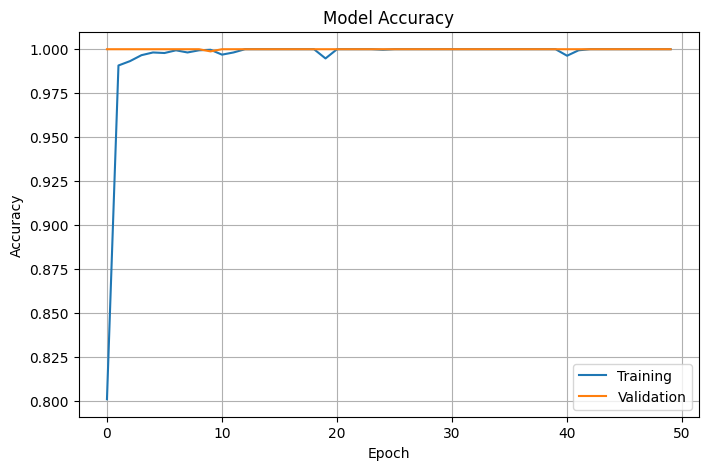

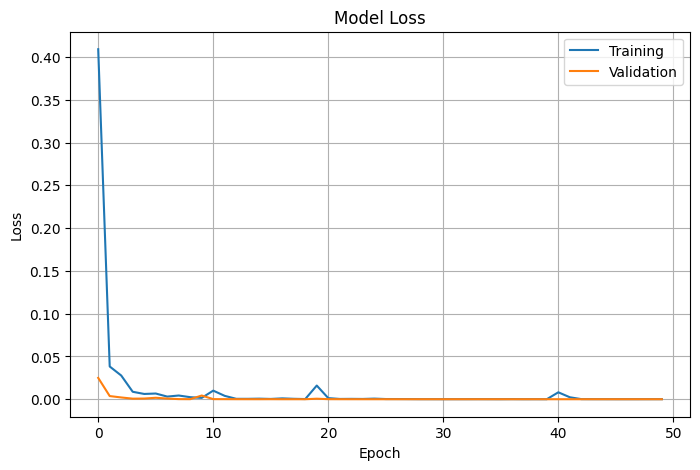

In [12]:

# =============================================================================
# Step 6: Model Performance Evaluation (ADDED BLOCK)
# =============================================================================
print("\nEvaluating model on test data...")
# Get predictions for the test set
y_pred_prob = model.predict(validation_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Print metrics
print("\nConfusion Matrix:")
print(confusion_matrix(test_y, y_pred))

print("\nClassification Report:")
print(classification_report(test_y, y_pred))

# Visualize training history
def plot_metric(history, metric):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history[metric], label='Training')
    plt.plot(history.history['val_'+metric], label='Validation')
    plt.title('Model ' + metric.capitalize())
    plt.ylabel(metric.capitalize())
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metric(history, 'accuracy')
plot_metric(history, 'loss')

In [13]:
# =============================================================================
# Step 7: Prediction and Final Map Creation
# =============================================================================
print("\nCreating the final map... This may take some time.")

prediction_map = np.zeros(arrLabels.shape, dtype=np.uint8)
pad = 2
total_rows = arrLabels.shape[0] - 2 * pad

for r_idx, r in enumerate(range(pad, arrLabels.shape[0] - pad)):
    if r_idx % 100 == 0:
        print(f"Processing row {r_idx} of {total_rows}...")

    cols = np.arange(pad, arrLabels.shape[1] - pad)
    chips_in_row = []
    for c in cols:
        chip = arrFeatures_fuzzy[:, r - pad:r + pad + 1, c - pad:c + pad + 1]
        chips_in_row.append(chip)

    chips_in_row = np.array(chips_in_row).transpose(0, 2, 3, 1)
    prediction = model.predict(chips_in_row, batch_size=2048, verbose=0).argmax(axis=1)
    prediction_map[r, pad:arrLabels.shape[1] - pad] = prediction + 1

print("Processing complete!")


Creating the final map... This may take some time.
Processing row 0 of 3704...
Processing row 100 of 3704...
Processing row 200 of 3704...
Processing row 300 of 3704...
Processing row 400 of 3704...
Processing row 500 of 3704...
Processing row 600 of 3704...
Processing row 700 of 3704...
Processing row 800 of 3704...
Processing row 900 of 3704...
Processing row 1000 of 3704...
Processing row 1100 of 3704...
Processing row 1200 of 3704...
Processing row 1300 of 3704...
Processing row 1400 of 3704...
Processing row 1500 of 3704...
Processing row 1600 of 3704...
Processing row 1700 of 3704...
Processing row 1800 of 3704...
Processing row 1900 of 3704...
Processing row 2000 of 3704...
Processing row 2100 of 3704...
Processing row 2200 of 3704...
Processing row 2300 of 3704...
Processing row 2400 of 3704...
Processing row 2500 of 3704...
Processing row 2600 of 3704...
Processing row 2700 of 3704...
Processing row 2800 of 3704...
Processing row 2900 of 3704...
Processing row 3000 of 3704...


Prediction map successfully saved to file: CNN_predicted_map_RAM_OK.tif


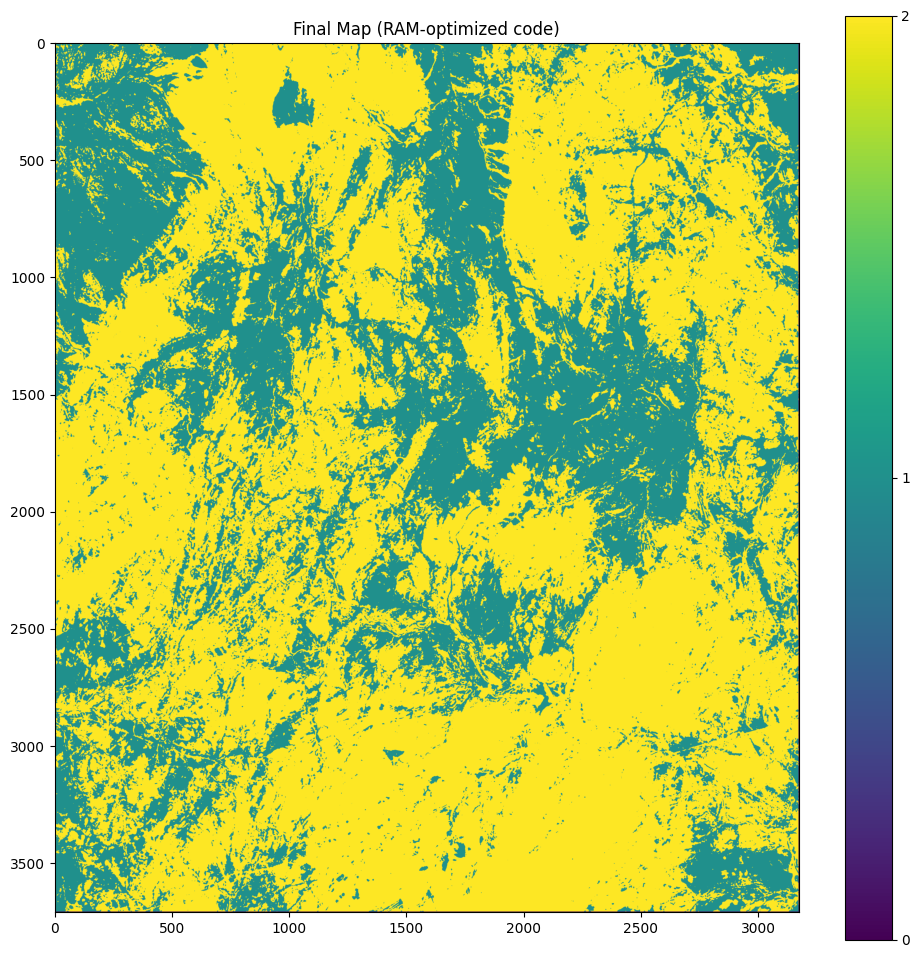

In [14]:
# =============================================================================
# Step 8: Export and Visualize Result (ADDED BLOCK)
# =============================================================================
outFile = 'CNN_predicted_map_RAM_OK.tif'
raster.export(prediction_map, dsFeatures, filename=outFile, dtype='int')
print(f"\nPrediction map successfully saved to file: {outFile}")

plt.figure(figsize=(12, 12))
plt.imshow(prediction_map, cmap='viridis')
plt.title("Final Map (RAM-optimized code)")
plt.colorbar(ticks=np.arange(n_classes + 2))
plt.show()